In [54]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az

%matplotlib inline
from IPython.display import Math, Latex

/Users/m102417/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [56]:
# load a dataset that is essentially Gaussian
data = np.loadtxt('./data/chemical_shifts.csv')
print(data)
stats.describe(data)

[51.06 55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43
 53.   56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58
 51.36 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82
 54.99 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]


DescribeResult(nobs=48, minmax=(47.72, 68.58), mean=53.49645833333333, variance=11.945304210992907, skewness=2.1034790868816637, kurtosis=6.8659549772299435)

# Student's t-distribution                                                        
As a general rule, Bayesians prefer to encode assumptions directly into the model by using different priors and likelihoods rather than through ad hoc heuristics such as outlier removal rules.One very useful option when dealing with outliers and Gaussian distributions is to replace the Gaussian likelihood with a Student's t-distribution. This distribution has three parameters: the mean, the scale (analogous to the standard deviation), and the degrees of freedom, which is usually referred to using the Greek letter &nu; , that can vary in the interval [0, ∞]. 

Following Kruschke's nomenclature, we are going to call  the normality parameter, since it is in charge of controlling how normal-like the Student's t-distribution is. For a value of &nu;=1, we get a distribution with very heavy tails, which is also known as Cauchy or Lorentz distribution. This last name is especially popular among physicists. By heavy tails, we mean that it is more probable to find values away from the mean compared to a Gaussian, or in other words values are not as concentrated around the mean as in a lighter tail distribution like the Gaussian. For example, 95% of the values from a Cauchy distribution are found between -12.7 and 12.7. Instead, for a Gaussian (with a standard deviation of one), this occurs between -1.96 and 1.96.

On the other side of the parameter space, when &nu; approaches infinity, we recover the Gaussian distribution (you can't be more normal than the normal distribution, right?). A very curious feature of the Student's t-distribution is that it has no defined mean when &nu; <= 1. Of course, in practice, any finite sample from a Student's t-distribution is just a bunch of numbers from which it is always possible to compute an empirical mean. Is the theoretical distribution itself the one without a defined mean. Intuitively, this can be understood as follows: the tails of the distribution are so heavy that at any moment it could happen that we get a sampled value from almost anywhere from the real line, so if we keep getting numbers, we will never approximate to a fixed value. Instead, the estimate will keep wandering around. Just try the following code several times (and then change df to a larger number, such as 100):

-1.1797009849746842

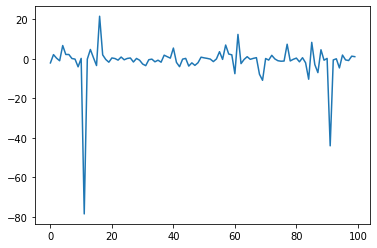

In [46]:
x = stats.t(loc=0, scale=1, df=1).rvs(100)
#print(x)
plt.plot(x)
np.mean(x) 

The variance of this distribution is only defined for values of &nu; >2. So, be careful that the scale of the Student's t-distribution is not the same as the standard deviation. For &nu; > 2, the distribution has no defined variance and hence no defined standard deviation. The scale and the standard deviation become closer and closer as  &nu; approaches infinity:

(-5, 5)

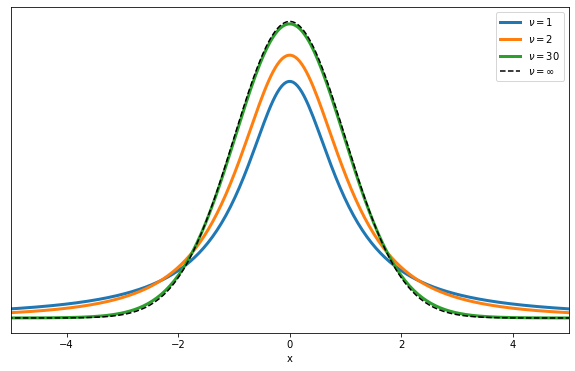

In [26]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

Now, we will modify the model from 07GaussianInferences to use the Student-T distribution instead of the normal distribution, like so:

In [52]:
display(Math(r'\mu \sim U(l,h)')) #a uniform distribution
display(Math(r'\sigma \sim | \ N(0,\sigma_\sigma) \ |'))
display(Math(r'\nu \sim Exp(\lambda)'))
display(Math(r'y \sim T(\mu,\sigma, \nu)')) #a normal distribution

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note: Exp stands for an expodential distribution with parameter lambda.  T is the Student-T distribution (the part of the model we are changing)

Below is the PyMC3 model.  A cautionary word here is that the exponential in PyMC3 is parameterized with the inverse of the mean.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3166.12draws/s]
/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c298cc1d0>,
      dtype=object)

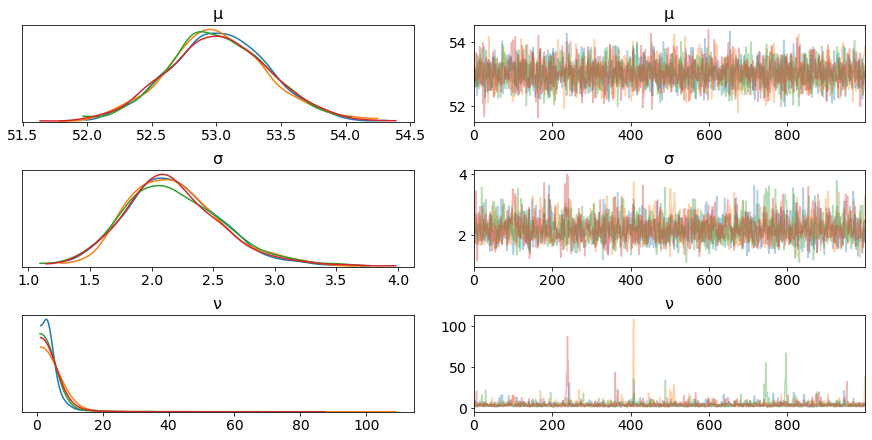

In [57]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)  # 30 is a pretty good value to get the student-t to be 'similar' to gausian.
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
az.plot_trace(trace_t)

In [58]:
az.summary(trace_t)

/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.017,0.385,0.007,0.005,52.305,53.760,3051.0,3049.0,3071.0,2860.0,1.0
σ,2.189,0.399,0.009,0.007,1.462,2.958,1991.0,1871.0,2114.0,2049.0,1.0
ν,4.576,4.496,0.123,0.087,1.142,9.047,1342.0,1342.0,2097.0,1567.0,1.0


Compare this to the model in 07GaussianInference!

The estimation of &mu; between both models is similar, with a difference of ≈0.5. The estimation of &sigma; changes from ≈3.5 to ≈2.1. This is a consequence of the Student's t-distribution giving less weight (being less shocked) by values away from the mean. We can also see that &nu;≈4.5, that is, we have a not very Gaussian-like distribution and instead one with heavier tails.

Now, we are going to do a posterior predictive check of the Student's t model and we are going to compare it to the Gaussian model:

100%|██████████| 100/100 [00:00<00:00, 1396.89it/s]
/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


(40, 70)

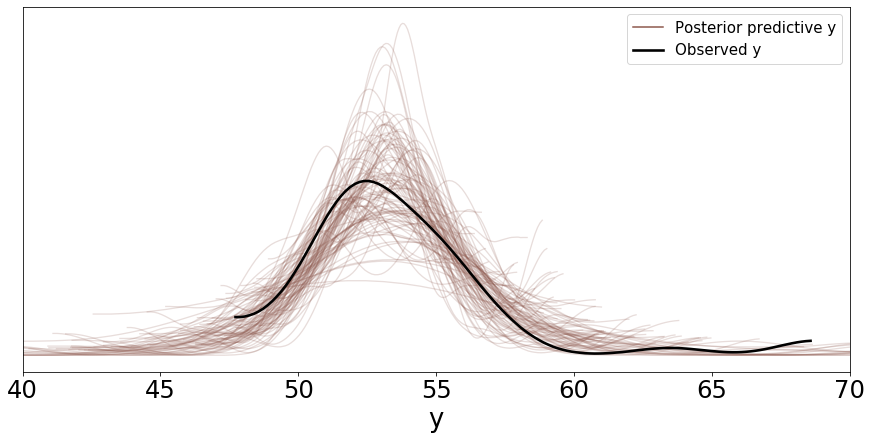

In [60]:
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
ax = az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)




Using the Student's t-distribution in our model leads to predictive samples that seem to better fit the data in terms of the location of the peak of the distribution and also its spread. Notice how the samples extend far away from the bulk of the data, and how a few of the predictive samples looks very flat. This is a direct consequence of the Student's t-distribution expecting to see data points far away from the mean or bulk of the data, and this is the reason we are setting xlim to [40, 70]